# Portfolio Management Project: Tangency Portfolio &  Capital Market Line

---

&nbsp;&nbsp; This Project implemented Scipy Optimization Method to construct a tangency portfolio with stocks from Tesla, Apple, J.P. Morgan, Amazon, and Costco. It also includes the corresponding Capital Market Line with assumption of 5% One-Year Treasury Bill Rate. Efficiency of this portfolio construction is measured by Sharpe Ratio of the next year portfolio performance. The following is a brief outline of the project:
<font color = "darkgrey">
* Data Processing
* Exploratory Data Analysis
* Risk & Return Relationship of Portfolio
* Maximal Sharpe Ratio & Minimal Risk
* Efficiency Frontier & Capital Market Line
* Verification for Efficiency of Portfolio Construction </font>

#### Reference

---
[1] : Brealey, Myers, and Allen Chapters 7 and 8.1 

[2] : Algorithmic Portfolio Optimization in Python: <https://kevinvecmanis.io/finance/optimization/2019/04/02/Algorithmic-Portfolio-Optimization.html>

[3] : Kaggle Portfolio Management:
<https://www.kaggle.com/code/harshalnikose/portfolio-management> 



#### Data Processing<font color = "darkgrey"> 

---

* Imported various Python Packages 
* Extracted Stock Data from Yahoo Finance</font>

In [29]:
#Packages Imported
import numpy as np
import pandas as pd
from yahoofinancials import YahooFinancials
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plot
import scipy.optimize as spyop



In [30]:
#Load Data
TSLA = yf.download("TSLA", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Google
AAPL = yf.download("AAPL", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Apple
JPM = yf.download("JPM", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Facebook
AMZN = yf.download("AMZN", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Amazon
COST = yf.download("COST", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Microsoft
STK_list = [TSLA, AAPL, JPM, AMZN, COST]
print(TSLA.shape, AAPL.shape, JPM.shape, AMZN.shape,COST.shape,)



[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(3032, 6) (3032, 6) (3032, 6) (3032, 6) (3032, 6)


In [31]:
#Combine Data into one Dataframe
STK_df = pd.concat([company['Close'] for company in STK_list], axis=1)
STK_df.columns = ['TSLA', 'AAPL', 'JPM', 'AMZN', 'COST']
STK_df.head()

,TSLA,AAPL,JPM,AMZN,COST
Date,,,,,
2012-05-21,1.918000,20.045713,32.509998,10.9055,83.730003
2012-05-22,2.053333,19.891787,34.009998,10.7665,83.379997
2012-05-23,2.068000,20.377144,34.259998,10.8640,83.309998
2012-05-24,2.018667,20.190001,33.970001,10.7620,84.480003
2012-05-25,1.987333,20.081785,33.500000,10.6445,84.480003


#### Exploratory Data Analysis

---

<font color = "darkgrey">
&nbsp;&nbsp;
Based on the graph of the Stock Close Price v.s. Date, the years before 2016 performed quite different from the following years, so only data after 2016 will be included as references.<br />

&nbsp;&nbsp;Specifically data from 2016-06 to 2023-06 will be used to measure the yearly average return and yearly risk (fluctuations) of the stock to approach the optimal weights of each stock for the Tangency Portfolio.<br />

&nbsp;&nbsp;Daily Return is measured in log returns, which emphasizes negative values, and such property is consistant with our unwantedness of loss.
</font>

<Axes: xlabel='Date'>

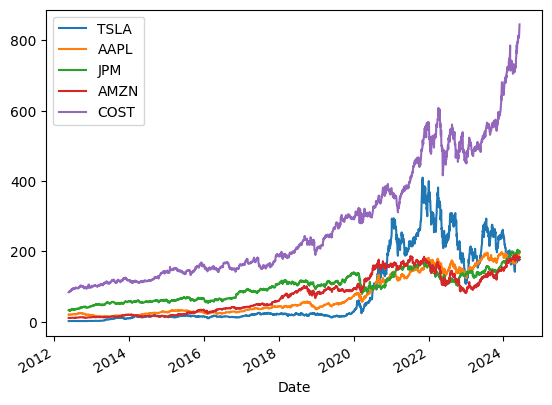

In [32]:
STK_df.plot()

In [93]:
#Measure the Daily return based on the close price of each stock
STK_df_raw = np.log(STK_df/STK_df.shift(1)).dropna()
STK_df_return = STK_df_raw[((STK_df_raw.index >= '2016-06-01') & (STK_df_raw.index < '2023-06-01')) ]

##### Related Mathematics Formula

---
* **$i$** is an abstract index for each stock, such that $i \in \{1,2,3,4,5 \} $, representing the 5 stocks in the portfolio
* Average return For Each Stock:
$$
    \mu_i = E[R_i] \\
$$

* Standard Deviation (Risk)  For Each Stock:
$$

    \sigma_i = \sqrt{E[(R_i - \mu_i)^2]} \\
$$
* Covariance & Correlation between Stocks: 
$$
    Cov[R_i, R_j] = E[(R_i-\mu_i)(R_j-\mu_j)]\\
$$
$$
    Corr_{ij} (\rho_{ij}) = \frac{Cov[R_i, R_j]}{\sigma_i \sigma_j}
$$

* **Overall Standard Deviation (Risk) for the Portfolio with weights ($\omega_i$):**
$$
    \sqrt{\sum_{i=1}^n \omega_i^2 \sigma_i^2 + \sum_{i\neq j} \omega_i \omega_j \sigma_i \sigma_j \rho_{ij}}
    
$$

Text(0.5, 1.0, 'Bar Chart for Average Return')

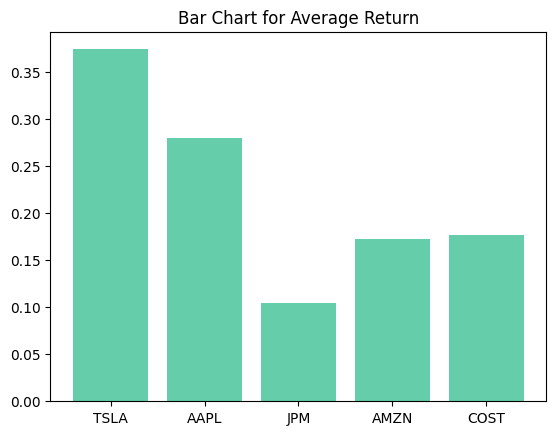

In [94]:
#calculate mean, standard deviation and covariance
R_mu = STK_df_return.mean() * 252
plot.bar(R_mu.index, R_mu, color = 'mediumaquamarine')
plot.title("Bar Chart for Average Return")

Text(0.5, 1.0, 'Bar Chart for Magnitude of Risk')

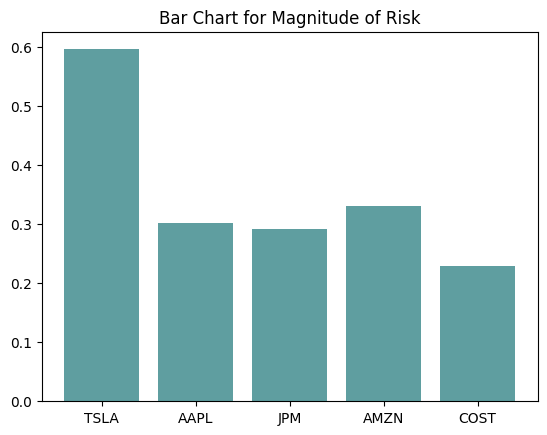

In [95]:
R_std = STK_df_return.std() * np.sqrt(252)
plot.bar(R_std.index, R_std, color = 'cadetblue')
plot.title("Bar Chart for Magnitude of Risk")

In [96]:
R_corr = STK_df_return.corr()
R_corr.style.background_gradient(cmap='GnBu')


,TSLA,AAPL,JPM,AMZN,COST
TSLA,1.000000,0.458474,0.267061,0.416746,0.288892
AAPL,0.458474,1.000000,0.445725,0.628734,0.513189
JPM,0.267061,0.445725,1.000000,0.301937,0.322676
AMZN,0.416746,0.628734,0.301937,1.000000,0.462207
COST,0.288892,0.513189,0.322676,0.462207,1.000000


#### Risk & Return Relationship of Portfolio

---

<font color = "darkgrey">

* Define function for measuring the overall risk of the Portfolio
* Simulate 10,000 groups of weights for stocks in the Portfolio, and plot the resulted return and risk
* Color the return & risk pair with its Sharpe Ratio
</font>

In [97]:
# Assume 1 yr treasury bill rate is 5%
TRSRY = 0.05

In [98]:
def Std_Portfolio(weights, std_ls, corr_mx):
    var_port = 0
    for i in range(len(std_ls)):
        var_port = var_port + weights[i]**2 * std_ls.iloc[i]**2 
        for j in range(i+1, len(std_ls)):
            var_port = var_port+ 2*weights[i]*weights[j]*std_ls.iloc[i]*std_ls.iloc[j]*corr_mx.iloc[i,j]
    std_port = np.sqrt(var_port)
    return std_port
    

In [99]:
# sample 10,000 combination of stocks and plot them
def Stat_Portfolio(weights, mu_ls, std_ls, corr_mx, T_rate ):
    pm = sum([weights[l] * R_mu.iloc[l] for l in range(len(mu_ls))]) 
    pstd = Std_Portfolio(weights,std_ls,corr_mx) 
    psharpe = (pm-T_rate)/pstd
    return [pm, pstd, psharpe]

iter = 10000
pm = []
pstd = []
psharpe = []

for k in range(iter):   
    weights_p = np.random.dirichlet(np.ones(len(STK_df_return.columns)),size = 1)[0]
    port_stat = Stat_Portfolio(weights_p, R_mu, R_std, R_corr, TRSRY)
    pm.append(port_stat[0])
    pstd.append(port_stat[1])
    psharpe.append(port_stat[2])




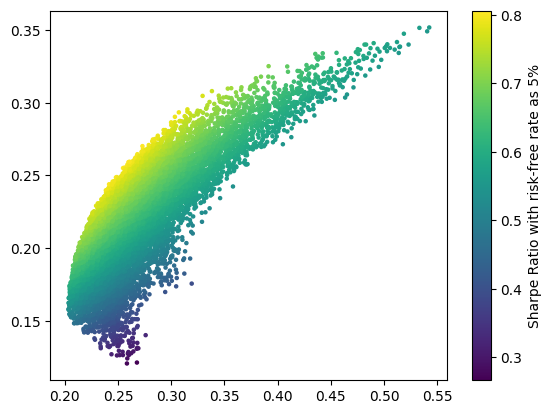

In [100]:
plot.scatter(pstd, pm, c = psharpe, s=5)
plot.colorbar(label="Sharpe Ratio with risk-free rate as 5%")

#### Maximal Sharpe Ratio & Minimal Risk

---

<font color="darkgrey">

* Define functions, constraints, bounds, and initial condition for applying Scipy Optimization
* Plot the Point with Minimal Risk & the Point with Minimal Sharpe Ratio
</font>

In [101]:
def Min_Risk(weights):
    return Stat_Portfolio(weights, R_mu, R_std, R_corr, TRSRY)[1]

def Max_Sharpe(weights):
    return -Stat_Portfolio(weights, R_mu, R_std, R_corr, TRSRY)[2]

def M_Return(weights):
     return Stat_Portfolio(weights, R_mu, R_std, R_corr, TRSRY)[0]

In [102]:
Cons = ({'type': 'eq','fun': lambda w: np.sum(w) - 1})
Bnds = (((0,1),) * len(STK_df.columns))
Init = [1/len(STK_df.columns)] * len(STK_df.columns)
print(Bnds)
print(Init)

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
[0.2, 0.2, 0.2, 0.2, 0.2]


In [103]:
#Find the weights combination with minimal risk
Min_Risk_W = spyop.minimize(Min_Risk,Init, 
                            method = 'SLSQP', 
                            bounds = Bnds, 
                            constraints = Cons )['x']
Min_Risk_W

array([2.90921971e-18, 4.03388539e-02, 2.88045489e-01, 9.17036033e-02,
       5.79912054e-01])

In [104]:
Min_Risk_result = Stat_Portfolio(Min_Risk_W, R_mu, R_std, R_corr, TRSRY)
Min_Risk_pm = Min_Risk_result[0]
Min_Risk_pstd = Min_Risk_result[1]

In [105]:
#Find the weights combination with maximal Sharpe Ratio
Max_Sharpe_W = spyop.minimize(Max_Sharpe,
                              Init, method = 'SLSQP', 
                              bounds = Bnds, 
                              constraints = Cons )['x']
Max_Sharpe_W

array([1.24682991e-01, 5.92662788e-01, 1.23599048e-17, 0.00000000e+00,
       2.82654221e-01])

In [106]:
Max_Sharpe_result = Stat_Portfolio(Max_Sharpe_W, R_mu, R_std, R_corr, TRSRY)
Max_Sharpe_pm = Max_Sharpe_result[0]
Max_Sharpe_pstd = Max_Sharpe_result[1]
Max_Sharpe_psharpe = Max_Sharpe_result[2]

Text(0.26138452018512626, 0.2627463731862672, 'Max Sharpe Ratio is 0.8139')

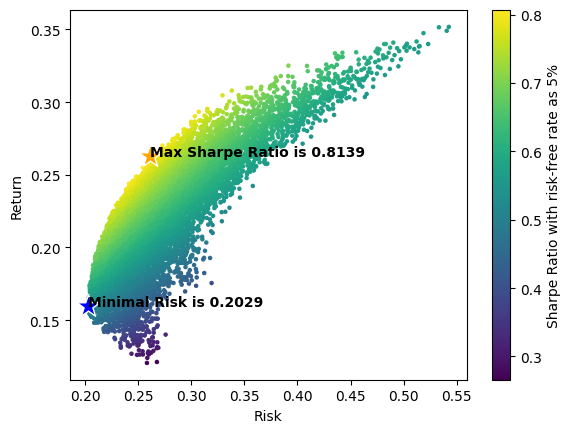

In [107]:
fig, ax = plot.subplots()
grph = ax.scatter(pstd, pm, c = psharpe, s=5)
ax.set_xlabel("Risk")
ax.set_ylabel("Return")
plot.colorbar(grph, label="Sharpe Ratio with risk-free rate as 5%")

ax.scatter(Min_Risk_pstd, Min_Risk_pm,marker = '*', c='b',edgecolor = 'white', s = 300)
ax.scatter(Max_Sharpe_pstd, Max_Sharpe_pm,marker = '*', c='orange',edgecolor = 'white', s = 300)
ax.annotate(f'Minimal Risk is {Min_Risk_pstd.round(4)}', (Min_Risk_pstd, Min_Risk_pm), weight = "bold")
ax.annotate(f'Max Sharpe Ratio is {Max_Sharpe_psharpe.round(4)}', (Max_Sharpe_pstd, Max_Sharpe_pm), weight = "bold")

#### Efficiency Frontier & Capital Market Line

---

<font color = "darkgrey">

* Find Points with Maximal Sharpe Ratio for given returns as illustration for the Efficiency Frontier
* Use the Point with Maximal Sharpe Ratio and the Point for the risk-free return to construct the Capital Market Line
</font>

In [108]:
target_m= np.linspace(Min_Risk_pm,np.max(pm),50)

EF_m = []
EF_std = []
for target in target_m:
    Cons_EF = ({'type': 'eq','fun': lambda w: np.sum(w) - 1},
                {'type': 'eq','fun': lambda w: M_Return(w) - target})
    w = spyop.minimize(Max_Sharpe,Init, method = 'SLSQP', bounds = Bnds, constraints = Cons_EF )['x']
    r = Stat_Portfolio(w, R_mu, R_std, R_corr, TRSRY)
    EF_m.append(r[0])
    EF_std.append(r[1])


Text(0.26138452018512626, 0.2627463731862672, 'Max Sharpe Ratio is 0.8139')

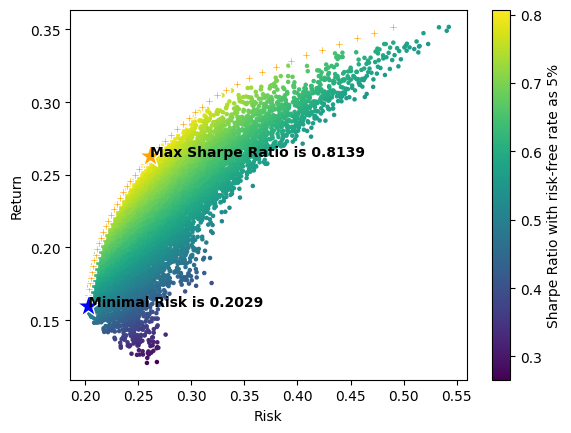

In [109]:
fig, ax = plot.subplots()
grph = ax.scatter(pstd, pm, c = psharpe, s=5)
ax.set_xlabel("Risk")
ax.set_ylabel("Return")
plot.colorbar(grph, label="Sharpe Ratio with risk-free rate as 5%")

ax.scatter(EF_std, EF_m, marker = 'P', c='orange', edgecolors='w')
ax.scatter(Min_Risk_pstd, Min_Risk_pm,marker = '*', c='b',edgecolor = 'white', s = 300)
ax.scatter(Max_Sharpe_pstd, Max_Sharpe_pm,marker = '*', c='orange',edgecolor = 'white', s = 300)
ax.annotate(f'Minimal Risk is {Min_Risk_pstd.round(4)}', (Min_Risk_pstd, Min_Risk_pm), weight = "bold")
ax.annotate(f'Max Sharpe Ratio is {Max_Sharpe_psharpe.round(4)}', (Max_Sharpe_pstd, Max_Sharpe_pm), weight = "bold")



Text(0.26138452018512626, 0.2627463731862672, 'Max Sharpe Ratio is 0.8139')

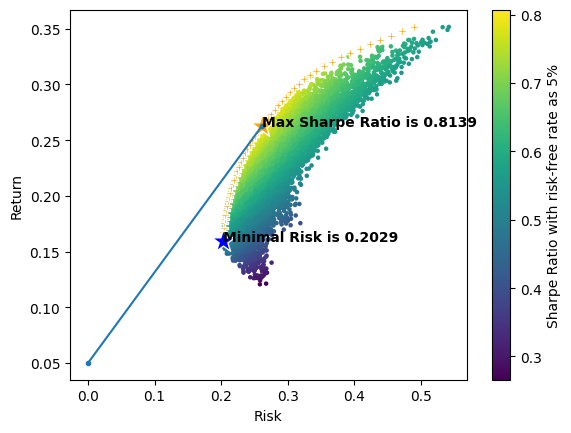

In [110]:
fig, ax = plot.subplots()
grph = ax.scatter(pstd, pm, c = psharpe, s=5)
ax.set_xlabel("Risk")
ax.set_ylabel("Return")
plot.colorbar(grph, label="Sharpe Ratio with risk-free rate as 5%")

x1, y1 = [0, Max_Sharpe_pstd], [TRSRY, Max_Sharpe_pm]
ax.plot(x1, y1, marker='.')

ax.scatter(EF_std, EF_m, marker = 'P', c='orange', edgecolors='w')
ax.scatter(Min_Risk_pstd, Min_Risk_pm,marker = '*', c='b',edgecolor = 'white', s = 300)
ax.scatter(Max_Sharpe_pstd, Max_Sharpe_pm,marker = '*', c='orange',edgecolor = 'white', s = 300)
ax.annotate(f'Minimal Risk is {Min_Risk_pstd.round(4)}', (Min_Risk_pstd, Min_Risk_pm), weight = "bold")
ax.annotate(f'Max Sharpe Ratio is {Max_Sharpe_psharpe.round(4)}', (Max_Sharpe_pstd, Max_Sharpe_pm), weight = "bold")



#### Verification for Efficiency of Portfolio Construction 

---

<font color = 'darkgrey'>
&nbsp;&nbsp; Based on the statistics of the portfolio with equal weights and the portfolio with optimal weights, it is clear that the optimal weights produced a higher return average of 26.27%, a slightly lower risk 17.36%, and a sharpe ratio **1.225** which is 24%  higher than the portfolio with equal weights.

</font>


In [119]:
STK_df_test = STK_df_raw[(STK_df_raw.index >= '2023-06-01') & (STK_df_raw.index <= '2024-06-20')]
tst_pm = STK_df_test.mean() * 252
tst_pstd = STK_df_test.std() * np.sqrt(252)
tst_corr = STK_df_test.corr()

In [120]:
#With Equal Weights
Eql_w = Stat_Portfolio(Init, tst_pm, tst_pstd, tst_corr, TRSRY)
Opt_w = Stat_Portfolio(Max_Sharpe_W, tst_pm, tst_pstd, tst_corr, TRSRY)
print(list(zip(['eql_return', 'eql_risk', 'eql_sharpe ratio'], list(Eql_w))))
print(list(zip(['opt_return', 'opt_risk', 'opt_sharpe ratio'], list(Opt_w))))
print(f'Reletive Increase in Sharpe Ratio:  {(Opt_w[2] - Eql_w[2])/Eql_w[2]}')


[('eql_return', 0.22167100938989304), ('eql_risk', 0.17414875511282993), ('eql_sharpe ratio', 0.9857722455648243)]
[('opt_return', 0.2627463731862672), ('opt_risk', 0.17364380234407006), ('opt_sharpe ratio', 1.225188404736246)]
Reletive Increase in Sharpe Ratio:  0.24287167776187676


In [121]:
iter_test = 10000
pm = []
pstd = []
psharpe = []

for k in range(iter_test):   
    weights_p = np.random.dirichlet(np.ones(len(STK_df_test.columns)),size = 1)[0]
    port_stat_tst = Stat_Portfolio(weights_p, tst_pm, tst_pstd, tst_corr, TRSRY)
    pm.append(port_stat_tst[0])
    pstd.append(port_stat_tst[1])
    psharpe.append(port_stat_tst[2])


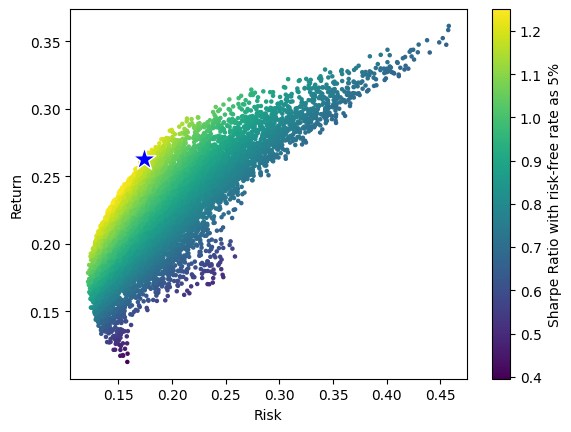

In [122]:
fig, ax = plot.subplots()
grph = ax.scatter(pstd, pm, c = psharpe, s=5)
ax.set_xlabel("Risk")
ax.set_ylabel("Return")
plot.colorbar(grph, label="Sharpe Ratio with risk-free rate as 5%")

ax.scatter(Opt_w[1],Opt_w[0],marker = '*', c='b',edgecolor = 'white', s = 300)

#### Conclusion

---

&nbsp;&nbsp; This project successfully constructs a tangency portfolio with 5 stocks, and shows the optimalism of the weights of the tangency portfolio compared with other weights. The graph indicates that the optimal weights generated based on previous few years stock data still have a optimal risk & return performance among 10,000 weights combinations which clearly lies on the Efficiency Frontier with a high Sharpe Ratio.